In [41]:
import pandas as pd
pd.options.mode.chained_assignment = None  
import numpy as np
import re
import regex
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate,StratifiedKFold

from sklearn.manifold import TSNE


from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
#colors
from matplotlib.colors import ListedColormap

# construct cmap
colors_names = ["wheat", "deeppink", "gold", "chocolate", "mistyrose", "lightgoldenrodyellow"]

category_order = ['cakes_cupcakes_snack_cakes', 'candy', 'chips_pretzels_snacks',
       'chocolate', 'cookies_biscuits', 'popcorn_peanuts_seeds_related_snacks']
snack_cmap = ListedColormap(sns.color_palette(colors_names).as_hex())

Now that we learned a lot about our data, it is time to try model our data  

In [192]:
food_train_df = pd.read_csv('data/food_train.csv')
food_nutrients_df = pd.read_csv('data/food_nutrients.csv')
nutrients_mapping_df = pd.read_csv('data/nutrients.csv')


In [251]:
food_test_df = pd.read_csv('data/food_test.csv')



# Snack2Vec

### 1. Preprocessing

In [11]:

def extract_ingredients(s):
    s = re.sub('[\(\[].*?[\)\]]', '', str(s))
    s = regex.sub(r'\([^()]*+(?:(?R)[^()]*)*+\)', '', s)
    s = re.sub(r"[!?'\]{}(;[.:+)*]", ' ', s)
    ingredients_list = s.split(",")
    ingredients_list=[i.strip() for i in  ingredients_list ]
    return ingredients_list


def snac2vec(ingredients,model,n_ingredient):
    vectors = []
    ingredients = ingredients[:np.min([n_ingredient,len(ingredients)])]
    for item in ingredients:
        if item in model.wv.vocab:
            vectors.append(model.wv.get_vector(item))
    return np.mean(vectors,axis=0)

food_train_df['ingredients']=food_train_df.ingredients.fillna('unk')
food_train_df['ingredient list'] = food_train_df.ingredients.apply(extract_ingredients)
snacks_vector_df = food_train_df[['ingredient list','category']]



### 2. Ingredients Embedding


Here we will train a fasttext model with the ingredient lists as our corpus. Fasttext method for word embedding is suitable for us because it can handle very good oov cases (such as in the test) based on character ngrams. We tried the same process with Word2vec method and for the classification task it didn't change much, so we picked Fasttext.

Here i will limit the model for the 10 first ingredients

In [12]:
from gensim.models import FastText,Word2Vec

n_ingredient = 10

ingredient_list = food_train_df['ingredient list'].tolist()
# we will limit the list into the first 10th ingredients 
ingredient_list_trimmed = [sublist[:np.min([n_ingredient,len(sublist)])] for sublist in ingredient_list]

#train fasttext model 
ingredient_model_fasttext = FastText(ingredient_list_trimmed, size=128, window=4, min_count=1,iter=40 ,workers=5,sg=1)

def snac2vec_fasttext(ingredients,model,n_ingredient):
    vectors = []
    ingredients = ingredients[:np.min([n_ingredient,len(ingredients)])]
    for item in ingredients:
        vectors.append(model.wv.get_vector(item))
    return np.mean(vectors,axis=0)

So, Now that we have a continuous vector space of ingredients ,we can use cosine similarity to match similar ingredients

In [19]:
ingredient_model_fasttext.wv.most_similar('feta cheese')

[('gouda cheese', 0.972714900970459),
 ('asiago cheese', 0.9611470103263855),
 ('impastata cheese', 0.9573835134506226),
 ('bleu cheese', 0.9486173391342163),
 ('mozzarella cheese', 0.9478099346160889),
 ('nacho cheese', 0.940189003944397),
 ('romano cheese', 0.9315943717956543),
 ('cheese', 0.93033367395401),
 ('goat cheese', 0.9236618280410767),
 ('blue cheese', 0.9214730262756348)]

Good, cheese are similar, can we get more complex similarities ?

In [20]:
ingredient_model_fasttext.wv.most_similar('zucchini')

[('yams', 0.7692513465881348),
 ('arrowrrot', 0.7352067232131958),
 ('brussel sprouts', 0.7237623929977417),
 ('farro', 0.7204749584197998),
 ('sprouted broccoli seed', 0.720370888710022),
 ('buckwheat groats', 0.7156940698623657),
 ('garbanzos', 0.7130926847457886),
 ('brussels sprout leaf', 0.7069469690322876),
 ('sprouted flaxseed', 0.7048147916793823),
 ('garbanzo bean', 0.7046922445297241)]

Wo-ho! vegtables that no one likes , they are all similar!

In [15]:
ingredient_model_fasttext.wv.most_similar('walnuts')

[('walnut', 0.8787872791290283),
 ('walnut halves', 0.8285243511199951),
 ('english walnuts', 0.8217734098434448),
 ('glazed walnuts', 0.8199856281280518),
 ('black walnuts', 0.8197928071022034),
 ('soy nuts & walnuts', 0.8085127472877502),
 ('shelled walnuts', 0.7997016906738281),
 ('chopped walnuts', 0.799649715423584),
 ('wal nuts', 0.799095630645752),
 ('raw walnuts', 0.7752242684364319)]

Different kinds of walnuts. The similarity is based both on the ngram-char level but mostly on the neighborhood of each ingredient. 

Now, lets see what happen if we avarage the first 10 ingredients (or less if the list is shorter)
to create a vector for each snack

In [21]:
snacks_vector_df = food_train_df[['ingredient list','category']]

snacks_vector_df['fasttext_vectors'] =snacks_vector_df.\
    apply(lambda x: snac2vec_fasttext(x['ingredient list'],ingredient_model_fasttext,n_ingredient), axis=1)

Lets plot the dim-reduced space with TSNE method :

In [17]:
from sklearn.manifold import TSNE
import time 
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
X = snacks_vector_df.fasttext_vectors.tolist()
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 31751 samples in 0.350s...
[t-SNE] Computed neighbors for 31751 samples in 227.345s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31751
[t-SNE] Computed conditional probabilities for sample 2000 / 31751
[t-SNE] Computed conditional probabilities for sample 3000 / 31751
[t-SNE] Computed conditional probabilities for sample 4000 / 31751
[t-SNE] Computed conditional probabilities for sample 5000 / 31751
[t-SNE] Computed conditional probabilities for sample 6000 / 31751
[t-SNE] Computed conditional probabilities for sample 7000 / 31751
[t-SNE] Computed conditional probabilities for sample 8000 / 31751
[t-SNE] Computed conditional probabilities for sample 9000 / 31751
[t-SNE] Computed conditional probabilities for sample 10000 / 31751
[t-SNE] Computed conditional probabilities for sample 11000 / 31751
[t-SNE] Computed conditional probabilities for sample 12000 / 31751
[t-SNE] Computed conditional probabilities for 

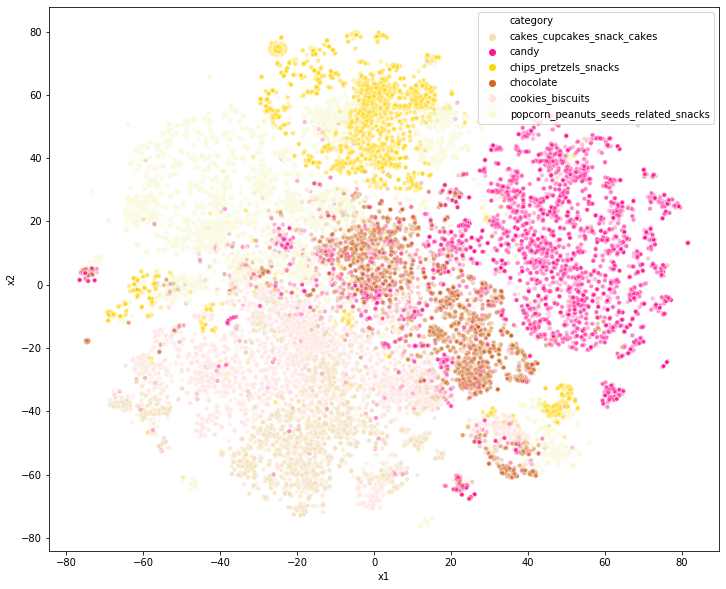

In [23]:
snacks_vector_df['x1'] = tsne_results[:,0];
snacks_vector_df['x2'] = tsne_results[:,1];
plt.figure(figsize=(12,10))
sns.scatterplot(
    x="x1", y="x2",
    hue="category",
    palette=sns.color_palette(colors_names).as_hex(),
    hue_order=category_order,
    data=snacks_vector_df,
    alpha=0.3,
    s=20
)
plt.show()

We can actually see that categories cluster together, based on the vector similarity. There are large areas of uncertainty in the middle of the plot where chocolate and cadny vectors are not separable.

Lets try to model it and see what RF  can get out of it

In [30]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X = snacks_vector_df.fasttext_vectors
y = snacks_vector_df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf_tree = RandomForestClassifier(1000)
clf_tree.fit(X_train.tolist(), y_train.tolist())
print(clf_tree.score(X_test.tolist(),y_test.tolist()))


y_pred_categories =clf_tree.predict(X_test.tolist())
labels = y_test.tolist()


prediction_eval = food_train_df.loc[y_test.index]
prediction_eval['predicted_category'] = y_pred_categories
prediction_eval['is_correct'] = (prediction_eval['category']==prediction_eval['predicted_category']).astype(int)

print(classification_report(prediction_eval['category'], prediction_eval['predicted_category']))


0.8910407809793733
                                      precision    recall  f1-score   support

          cakes_cupcakes_snack_cakes       0.92      0.85      0.88       741
                               candy       0.93      0.86      0.89      1521
               chips_pretzels_snacks       0.95      0.94      0.95       772
                           chocolate       0.75      0.84      0.79       729
                    cookies_biscuits       0.86      0.89      0.88      1088
popcorn_peanuts_seeds_related_snacks       0.91      0.94      0.93      1500

                            accuracy                           0.89      6351
                           macro avg       0.89      0.89      0.89      6351
                        weighted avg       0.89      0.89      0.89      6351



Not bad, based on just 10 ingredients we have 89% of accuracy. As we saw in the TSNE, Chocolate category is sharing similarites with other categories and it is hard for the model to classify. 

Lets check cases where we falsely  label snack as chocolate :

In [36]:
prediction_eval[(prediction_eval.is_correct==0) & (prediction_eval.predicted_category=='chocolate') ].head(5)


,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,ingredient list,predicted_category,is_correct
30278,33636,ferrara candy company,"almond bark, chocolate","chocolate bark [sugar, partially hydrogenated ...",47.0,g,1 section,candy,"[chocolate bark, cocoa, cocoa, whey powder, so...",chocolate,0
6511,7260,lindt & sprungli (schweiz) ag,strawberries and cream white chocolate truffle...,"white chocolate [sugar, cocoa butter, milk, sk...",36.0,g,3 balls,candy,"[white chocolate, vanillin, vegetable oil, sug...",chocolate,0
5964,6659,snack factory inc,"snack factory, pretzel crisps, thin, crunchy p...","coating: dark chocolate (sugar, chocolate liqu...",28.0,g,1 onz,popcorn_peanuts_seeds_related_snacks,"[coating dark chocolate, cocoa butter, milkfa...",chocolate,0
7408,8253,zingerman's coffee co.,chocolate almond egg fudge,"cane sugar, dark chocolate (cocoa beans, sugar...",60.0,g,1 egg,candy,"[cane sugar, dark chocolate, milk, almond past...",chocolate,0
8265,9204,reese's,"reese's, peanut butter cups","milk chocolate (sugar, cocoa butter, chocolate...",44.0,g,5 pieces,candy,[milk chocolate],chocolate,0


'strawberries and cream white chocolate truffles', ye well, we might find a way to fool the model but you wont fool me !. Anyway , seems that having chocolate in the ingredient is not enough for being a chocolate. 

Can we do better? lets try to move from an avg-vector into a more complex RNN architecture. We will use the fasttext model to construct an embedding matrix for the training data and learn with it a better representation.

In [47]:
import tensorflow as tf
from tensorflow.keras import layers,optimizers,losses,Model

def snack2vec_bilstm(embedding_matrix,embedding_dim,vocab_size,MAX_SEQUENCE_LENGTH):
        ingredients_layer =  layers.Embedding(vocab_size,
                             embedding_dim,
                             mask_zero=False,
                             weights=[embedding_matrix],
                             input_length=MAX_SEQUENCE_LENGTH,
                             trainable=False)

        x_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = ingredients_layer(x_input)
        
        #dropout
        embedded_sequences = layers.SpatialDropout1D(0.2)(embedded_sequences)
        #bilstm
        bilstm = layers.Bidirectional(layers.LSTM(128,return_sequences=True), name="bilstm")(embedded_sequences)
        
        #pooling
        avg_pool = layers.GlobalAveragePooling1D()(bilstm)
        max_pool = layers.GlobalMaxPooling1D()(bilstm)
        concat = layers.concatenate([avg_pool, max_pool])
        
        #dense
        dense = layers.Dense(128, activation="relu")(concat)
        x = layers.Dropout(0.2)(dense)

        output = layers.Dense(6, activation="softmax")(x)


        model = Model(inputs=x_input, outputs=output)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=0.01),
                      metrics=['accuracy'])
        #model.summary()
        
        return model
     

Here we will add an experimental tokenizer  - for OOV ingredients from the test , we will replace the ingredient with the most similar one, similar to what i've shown in the introduction. 

In [48]:
def test_ingredients_to_pad_sequence(test_set,model,word_index):
    #replace OOV ingredients with most similar ingredients by fasttext model.[Experimental]
    print(test_set.shape)
    test_sequence = []
    for snack in test_set:
        snack_sequence = []
        for ingredient in snack:
            index = word_index.get(ingredient,False )
            if not index:
                similar_word_replacement = model.wv.most_similar(ingredient)[0][0]
                index = word_index.get(similar_word_replacement,0 )
                snack_sequence.append(index)
            else: 
                snack_sequence.append(index)
        test_sequence.append(snack_sequence)
        
    test_sequence= pad_sequences(test_sequence, maxlen=n_ingredient, 
                     padding="post", truncating="post")
    return test_sequence

Now, we will train a fasttext model for each train set in the 5-fold cv. The test set will run through the oov-tokenizer. We will use the fasttext model to create a word embedding matrix with all the train ingredient vocab and then train the RNN model.

Due to report size limitations i've excluded tuning experiments. The parameters that i tuned for the task are:
fasttext model : window size (2,3,4) , epochs (30,40,100) ,skipgram (sg) = 1/0 (where 0 is utilize continuous bag of words instead of skipgram).

in the RNN:
i've tried several architectures which all gave similar results. Adam's learning rate, dropout probability. Also i've increaded the number of ingredients to 15 but 10 ingredients gave in most cases the same accuracy.


In [66]:
ingredient_list = food_train_df['ingredient list'].tolist()

n_ingredient = 15

food_train_df['ingredient_list_trimmed'] = ingredient_list_trimmed = [sublist[:np.min([n_ingredient,len(sublist)])] for sublist in ingredient_list]


X= food_train_df['ingredient_list_trimmed']
y = food_train_df['category']

val_loss_list = []
val_acc_list = []
n_split=5
for train_index,test_index in StratifiedKFold(n_split,shuffle=True).split(X,y):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=pd.get_dummies(y[train_index]),pd.get_dummies(y[test_index])
    #train fasttext model 
    ingredient_model_fasttext = FastText(size=128, window=4,alpha=0.05, min_count=1)  
    ingredient_model_fasttext.build_vocab(sentences=X_train)
    ingredient_model_fasttext.train(sentences=X_train, total_examples=len(X_train), epochs=40,sg=1) 


    #word index and train sequence
    word_index = {t.lower(): i+1 for i,t in enumerate(ingredient_model_fasttext.wv.vocab)}
    train_sequences = [[word_index.get(t, 0) for t in snack] for snack in X_train]
    train_sequences = pad_sequences(train_sequences, maxlen=n_ingredient, 
                     padding="post", truncating="post")
    
    embedding_dim  = ingredient_model_fasttext.wv.vector_size
    vocab_size = len(ingredient_model_fasttext.wv.vocab)+1

    MAX_SEQUENCE_LENGTH=n_ingredient
    #test
    test_sequences = test_ingredients_to_pad_sequence(X_test,ingredient_model_fasttext,word_index)

    
    # we initialize the matrix with random numbers
    embedding_matrix = (np.random.rand(vocab_size, embedding_dim) - 0.5) / 5.0
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        try:
            embedding_vector = ingredient_model_fasttext.wv.get_vector(word)
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        except:
            print('Failed')
            pass       
    print("train")
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    model = snack2vec_bilstm(embedding_matrix,embedding_dim,vocab_size,MAX_SEQUENCE_LENGTH)
    hist = model.fit(train_sequences, y_train,callbacks=[callback],validation_data=(test_sequences, y_test),
                     epochs=10, batch_size=256,verbose=0)
    val_loss,val_acc = model.evaluate(x=test_sequences,y=y_test)
    val_acc_list.append(val_acc),val_loss_list.append(val_loss)

(6351,)
train
199/199 [==============================] - 1s 4ms/step - loss: 0.2875 - accuracy: 0.9096
(6350,)
train
199/199 [==============================] - 1s 5ms/step - loss: 0.2874 - accuracy: 0.9083
(6350,)
train
199/199 [==============================] - 1s 5ms/step - loss: 0.3088 - accuracy: 0.9044
(6350,)
train
199/199 [==============================] - 1s 5ms/step - loss: 0.3054 - accuracy: 0.9079
(6350,)
train
199/199 [==============================] - 1s 5ms/step - loss: 0.2796 - accuracy: 0.9117


In [73]:
Acc = [np.round(np.mean(val_acc_list)-np.std(val_acc_list),3),np.round(np.mean(val_acc_list)+np.std(val_acc_list),3)]
print('mean accuracy +/- std : ',Acc)

mean accuracy +/- std :  [0.906, 0.911]


Seems that all the deep learning magic didnt change much. It might be that some of the snacks are not differentiable by their ingredients alone or that we failed to represent the snack space 

Ok , lets try something stronger, now we will deal with the description part using SOTA transformers. The code below trained using google-colab's gpu so the training itself is not shown here but added as an extra notebook:

We will use HuggingFace's transformers library to train Facebook's Roberta model , an optimized version of BERT. Our model utilize transfer learning as Roberta is already pre-trained on endless amount of texts. We will just fine-tune it to our importent task of snack description classification. Part of the script here is taken from HuggingFace Tensorflow tutorial (the encoder)

# Roberta


In [91]:
import transformers
from tensorflow.keras.layers import Dense, Input


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
    
    return np.array(all_tokens)

def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(6, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


X = food_train_df.description
Y = food_train_df.category


X_train,X_test,Y_train,Y_test = train_test_split(X,pd.get_dummies(Y),test_size=0.20)

max_vocab_len = X_train.str.split().str.len().max()
transformer_layer = transformers.TFRobertaModel.from_pretrained('roberta-base')
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')


I0810 22:01:31.099035 4398583232 configuration_utils.py:157] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/uri/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0810 22:01:31.100775 4398583232 configuration_utils.py:174] Model config {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_

In [92]:
model = build_model(transformer_layer, max_len=max_vocab_len)
model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 29)]              0         
_________________________________________________________________
tf_roberta_model_3 (TFRobert ((None, 29, 768), (None,  124645632 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_51 (Dense)             (None, 6)                 4614      
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Check description_classification_roberta.ipynb for full training run (i've needed colab GPU)

train_input = bert_encode(X_train.values, tokenizer, max_len=max_vocab_len)
test_input = bert_encode(X_test.values, tokenizer, max_len=max_vocab_len)
train_labels = Y_train

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=32
)

final accuracy for validation set - 92% ! (description_classification_roberta.ipynb)

The prediction csv is attached : prediction/roberta_predictions.csv

we've managed to get nice results from single features untill now , lets try another modality - images :

# Convolution NN

In [75]:
import IPython.display as display
import pathlib

from PIL import Image 
import matplotlib.pyplot as plt
#
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [77]:
# map files
data_dir = pathlib.Path('/Users/uri/Documents/Uri/school/dsapps/Project/data/foods_final/train')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#map classes based on folder names 
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')if item.name != ".DS_Store"])
print(CLASS_NAMES)

31751


Adding image augmentations via keras ImageDataGenerator

In [78]:
batch_size = 16
img_size = 140
img_dir = '/Users/uri/Documents/Uri/school/dsapps/Project/data/foods_final/train'
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)




train_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 25403 images belonging to 6 classes.
Found 6348 images belonging to 6 classes.


In [79]:
from tensorflow import keras

img_model = keras.Sequential([    
    keras.layers.Conv2D(16,3,padding='same', activation='relu', input_shape=(img_size, img_size, 3)),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(32,3,padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(64,3,padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=6, activation='softmax'),
])
img_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 140, 140, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [81]:
img_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['categorical_accuracy']
) 
img_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)

Epoch 1/20
1588/1588 [==============================] - 232s 146ms/step - loss: 1.6790 - categorical_accuracy: 0.3073 - val_loss: 1.5914 - val_categorical_accuracy: 0.3532
Epoch 2/20
1588/1588 [==============================] - 222s 140ms/step - loss: 1.5604 - categorical_accuracy: 0.3726 - val_loss: 1.5151 - val_categorical_accuracy: 0.3967
Epoch 3/20
1588/1588 [==============================] - 223s 140ms/step - loss: 1.5087 - categorical_accuracy: 0.4051 - val_loss: 1.4946 - val_categorical_accuracy: 0.4110
Epoch 4/20
1588/1588 [==============================] - 223s 140ms/step - loss: 1.4622 - categorical_accuracy: 0.4302 - val_loss: 1.4298 - val_categorical_accuracy: 0.4427
Epoch 5/20
1588/1588 [==============================] - 233s 147ms/step - loss: 1.4346 - categorical_accuracy: 0.4422 - val_loss: 1.3880 - val_categorical_accuracy: 0.4595
Epoch 6/20
1588/1588 [==============================] - 234s 148ms/step - loss: 1.4162 - categorical_accuracy: 0.4562 - val_loss: 1.3678 - v

In [94]:

test_labels=validation_generator.classes 
predictions=img_model.predict(validation_generator, verbose=1)
y_pred = np.argmax(predictions, axis=-1)

print(classification_report(test_labels, y_pred,target_names=list(validation_generator.class_indices.keys())))

397/397 [==============================] - 30s 76ms/step
                                      precision    recall  f1-score   support

          cakes_cupcakes_snack_cakes       0.43      0.33      0.38       757
                               candy       0.63      0.68      0.65      1516
               chips_pretzels_snacks       0.58      0.39      0.46       736
                           chocolate       0.39      0.34      0.36       754
                    cookies_biscuits       0.38      0.40      0.39      1056
popcorn_peanuts_seeds_related_snacks       0.53      0.65      0.58      1529

                            accuracy                           0.51      6348
                           macro avg       0.49      0.46      0.47      6348
                        weighted avg       0.51      0.51      0.50      6348



Nope..

Lets see some predictions :

1/1 [==============================] - 0s 829us/step


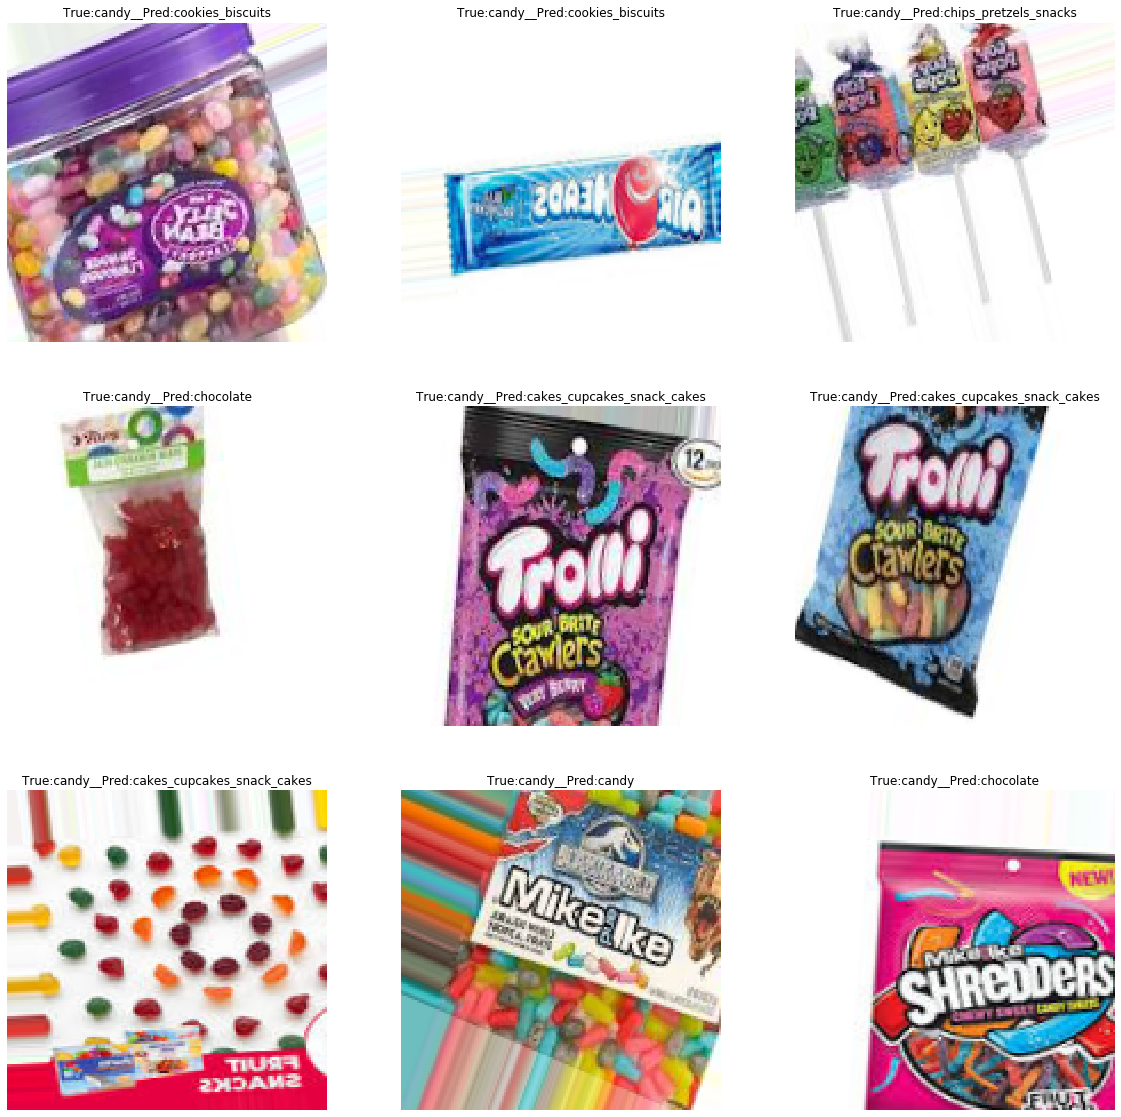

In [188]:
image_batch, label_batch = next(validation_generator)
CLASS_NAMES = list(validation_generator.class_indices.keys())
predictions_batch=img_model.predict(image_batch, verbose=1)
y_pred_batch = np.argmax(predictions, axis=-1)

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("float32"))
    label = np.argmax(label_batch[i])
    pred_label = y_pred_batch[i]
    title = 'True:'+CLASS_NAMES[label]+'__Pred:'+CLASS_NAMES[pred_label]
    plt.title(title,wrap=True)
    plt.axis("off")
    
    


Here are some prediction over the augmented validation set. Seems random (even tho we have 50% which is above chance level in 6 categories ).

I've managed to get to 59% whithout adding the augmented data but couldn't find a way to fight the overfitting  

Maybe there is a bug with the generator that i'm missing. not sure. Anyway the images are not enough for good classification.

Lets try something new, tree model, a better fit for categorical features.

# ML with pipeline over categorical and numerical features

In [248]:
#merge food_nutrients_df with nutrients_mapping_df
food_nutrients_merged = (food_nutrients_df.merge(nutrients_mapping_df, left_on='nutrient_id', right_on='nutrient_id')
          .reindex(columns=['idx', 'nutrient_id', 'name', 'amount','unit_name']))


#remove row with both kJ and KCAL, the kJ row is incorrect
food_nutrients_merged.drop(food_nutrients_merged[food_nutrients_merged.unit_name=='kJ'].index,inplace=True)


df_train = food_nutrients_merged.pivot(index='idx', columns='name', values='amount').reset_index(level=0).fillna(0)
df_train = df_train.merge(food_train_df,left_on='idx', right_on='idx')


#get household_serving
def get_serving_size_and_type(df,c):
    new_columns = df[str(c)].str.replace('(|)','').str.split(' ',expand=True)[[0,1]]
    return new_columns

df_train[['serving quant','serving type']]= get_serving_size_and_type(df_train,'household_serving_fulltext')
df_train['serving type'] =df_train['serving type'].astype(str)
df_train['brand'] = df_train['brand'].astype(str)

In [249]:
nutrients_col_names = food_nutrients_merged.name.unique()
other_cols = df_train.columns.drop(nutrients_col_names)
cols_to_drop = ['description','category','household_serving_fulltext','ingredients','idx','serving quant','serving_size_unit']


In [250]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


X = df_train.drop(cols_to_drop,axis=1)
y = df_train.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


categorical_features = ['serving type','brand']

training_cols = X.columns.tolist() 

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


numeric_features = [item for item in training_cols if item not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesClassifier(1500))])

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))


0.9105652653125492


good enough !

In [252]:

food_nutrients_merged.drop(food_nutrients_merged[food_nutrients_merged.unit_name=='kJ'].index,inplace=True)


df_test = food_nutrients_merged.pivot(index='idx', columns='name', values='amount').reset_index(level=0).fillna(0)
df_test = df_test.merge(food_test_df,left_on='idx', right_on='idx')


#get household_serving

df_test[['serving quant','serving type']]= get_serving_size_and_type(df_test,'household_serving_fulltext')
df_test['serving type'] =df_test['serving type'].astype(str)
df_test['brand'] = df_test['brand'].astype(str)

cols_to_drop = ['description','household_serving_fulltext','ingredients','idx','serving quant','serving_size_unit']

X_test_test = df_test.drop(cols_to_drop,axis=1)
y_pred = clf.predict(X_test_test)

In [259]:
d = {'idx':df_test.idx,'pred_cat':y_pred}
df_prediction_last_model = pd.DataFrame(d)
df_prediction_last_model.to_csv('ExtraTreesClassifier.csv')

predictions are in prediction/ExtraTreesClassifier.csv

During the process i've created a multi-input network that takes snack2vec, description embedding with glove, and the categorical + numerical features, the netowork didnt manage to get above 93% so i've excluded it because it does not seem like a good way to handle the data. i'm adding the network graph  plot. Giora if you have any clue on how to change that spacific architecture to work better i'd really like to know (regardless the project)

<img src='plots_extra/combine_nn.png' width="1000" height="240" align="center"/>


END